In [1]:
%load_ext autoreload
%autoreload 2

import sys
sys.path.append('../')
print(sys.path)

['/home/hieutt/RD-OpenMax_CAN_IDS/notebooks', '/home/hieutt/miniconda3/envs/torchtf/lib/python39.zip', '/home/hieutt/miniconda3/envs/torchtf/lib/python3.9', '/home/hieutt/miniconda3/envs/torchtf/lib/python3.9/lib-dynload', '', '/home/hieutt/miniconda3/envs/torchtf/lib/python3.9/site-packages', '../']


In [2]:
import os
import torch
import numpy as np
import pickle
import torch.nn.functional as F
import matplotlib.pyplot as plt
from tqdm import tqdm
from sklearn.metrics import roc_curve, roc_auc_score, confusion_matrix, f1_score, precision_score, recall_score, accuracy_score
from sklearn.manifold import TSNE
import seaborn as sns
from dataset import CANDatasetEnet as CANDataset
from rd_openmax import openmax_predict_rd
from model_init import *
from torchvision import transforms
from torch.utils.data import DataLoader


In [3]:
seed = 1
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
torch.cuda.manual_seed_all(seed)
np.random.seed(seed)
device = torch.device("cuda")

In [4]:
data_paths = {
    "close": "../data/set_04/test_01_known_vehicle_known_attack/preprocessed/5_percent/TFRecord_w64_s32/2",
    "open_all": "../data/set_04/test_03_known_vehicle_unknown_attack/preprocessed/five_features/TFRecord_w64_s32/2",
    "open_dos": "../data/set_04/test_03_known_vehicle_unknown_attack/preprocessed/one_type/dos/TFRecord_w64_s32/2",
    "open_double": "../data/set_04/test_03_known_vehicle_unknown_attack/preprocessed/one_type/triple/TFRecord_w64_s32/2",
    "open_force_neutral": "../data/set_04/test_03_known_vehicle_unknown_attack/preprocessed/one_type/force-neutral/TFRecord_w64_s32/2",
    "open_fuzzing": "../data/set_04/test_03_known_vehicle_unknown_attack/preprocessed/one_type/fuzzing/TFRecord_w64_s32/2",
    "open_triple": "../data/set_04/test_03_known_vehicle_unknown_attack/preprocessed/one_type/triple/TFRecord_w64_s32/2"
}

n_classes = 6
batch_size = 256
window_size = 32


In [5]:
from util import AddGaussianNoise, TwoCropTransform

train_dataset_folder = "../data/set_04/train_01/preprocessed/20_percent/TFRecord_w64_s32/2"
mean = (0.5, 0.5, 0.5)
std = (0.5, 0.5, 0.5)
normalize = transforms.Normalize(mean=mean, std=std)
transform = transforms.Compose([normalize])
train_transform = transforms.Compose([
    transforms.RandomApply([AddGaussianNoise(0., 0.05)], p=0.5),
    transforms.RandomErasing(p=0.3, scale=(0.02, 0.15)),
    transforms.Normalize(mean=mean, std=std)
])
# Khởi tạo dataset
train_dataset = CANDataset(root_dir=train_dataset_folder, window_size=32, is_train=True, transform=TwoCropTransform(train_transform))
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=8, pin_memory=True, drop_last=True)

In [6]:
# Load datasets
transform = transforms.Compose([
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

def create_loader(path, batch_size=batch_size, is_train=False):
    dataset = CANDataset(root_dir=path, window_size=window_size, is_train=is_train, transform=transform)
    loader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=False)
    return dataset, loader


In [7]:
datasets = {}
loaders = {}

for key, path in data_paths.items():
    datasets[key], loaders[key] = create_loader(path)

In [ ]:
# Configuration
# ckpt_path = "../save/CAN_TT_models/UniCon/UniCon_CAN_TT_mpncovresnet50_lr_0.05_decay_0.0001_bsz_256_trial_1_cosine_warm/ckpt_epoch_138.pth"
# class_model_path = "../save/CAN_TT_models/UniCon/UniCon_CAN_TT_mpncovresnet50_lr_0.05_decay_0.0001_bsz_256_trial_1_cosine_warm/ckpt_classifier_epoch_138.pth"
# weibull_path = ckpt_path.replace("ckpt_epoch_138.pth", "weibull_epoch_138.pkl")

ckpt_path = "../save/CAN_TT_models/UniCon/UniCon_CAN_TT_mpncovresnet50_lr_0.05_decay_0.0001_bsz_256_trial_1_cosine_warm/ckpt_epoch_150.pth"
class_model_path = "../save/CAN_TT_models/UniCon/UniCon_CAN_TT_mpncovresnet50_lr_0.05_decay_0.0001_bsz_256_trial_1_cosine_warm/ckpt_classifier_epoch_150.pth"
weibull_path = ckpt_path.replace("ckpt_epoch_150.pth", "weibull_epoch_150.pkl")

# ckpt_path = "../save/CAN_TT_models/UniCon/UniCon_CAN_TT_mpncovresnet50_lr_0.03_decay_0.0001_bsz_128_trial_F-DEF_v2_cosine_warm/ckpt_epoch_66.pth"
# class_model_path = "../save/CAN_TT_models/UniCon/UniCon_CAN_TT_mpncovresnet50_lr_0.03_decay_0.0001_bsz_128_trial_F-DEF_v2_cosine_warm/ckpt_classifier_epoch_66.pth"
# weibull_path = ckpt_path.replace("ckpt_epoch_66.pth", "weibull_epoch_66.pkl")

In [9]:
def change_state_dict(state_dict):
    """
    Because state dict in distributed GPU is different
    """
    new_state_dict = {}
    for k, v in state_dict.items():
        k = k.replace("module.", "")
        new_state_dict[k] = v
    return new_state_dict

In [10]:
from networks.con_mpncovresnet import ConTinyMPNCOVResNet, LinearClassifier
from rd_openmax import extract_class_stats, fit_weibull_rd, openmax_predict_rd

model = ConTinyMPNCOVResNet(
    attention='Cov',
    input_size=64,
    feat_dim=128
)
classifier = LinearClassifier(input_dim=8256, num_classes=n_classes)

model.to(device)
classifier.to(device)

ckpt = torch.load(ckpt_path, weights_only=False)
state_dict = ckpt['model']
state_dict = change_state_dict(state_dict)
model.load_state_dict(state_dict=state_dict)

ckpt = torch.load(class_model_path, weights_only=False)
state_dict = ckpt['model']
classifier.load_state_dict(state_dict=state_dict)

# --- Euclidean version ---
with open(weibull_path, 'rb') as f:
    weibull_data = pickle.load(f)
class_means = weibull_data['class_means']
weibull_models = weibull_data['weibull_models']


In [11]:
def evaluate_open_set(model, classifier, open_loader, class_means, weibull_models, device, best_thresh=0.7212):
    total_preds = []
    total_feats = []
    total_labels = []
    unk_probs = []

    model.eval()
    if classifier is not None:
        classifier.eval()

    with torch.no_grad():
        for images, labels in open_loader:
            if isinstance(images, (list, tuple)):
                images = images[0]

            images = images.to(device, non_blocking=True)
            labels = labels.to(device, non_blocking=True)

            # 🧠 Feature embedding
            feats = model.encoder(images) if classifier is not None else model(images)
            feats = F.normalize(feats, dim=1)
            feats_np = feats.cpu().numpy()
            total_feats.append(feats_np)

            for f, label in zip(feats_np, labels.cpu().numpy()):
                pred_class, unk_prob = openmax_predict_rd(f, class_means, weibull_models)
                total_preds.append((pred_class, unk_prob))
                total_labels.append(label)
                unk_probs.append(unk_prob)

    total_feats_np = np.concatenate(total_feats, axis=0)

    # Mapping labels: 0 = known, else = unknown
    mapped_label = [0 if l == 0 else 1 for l in total_labels]
    mapped_pred = [0 if p[1] < best_thresh else 1 for p in total_preds]

    return {
        "mapped_label": mapped_label,
        "mapped_pred": mapped_pred,
        "unk_probs": unk_probs,
        "total_feats": total_feats_np,
        "raw_preds": total_preds,
        "labels": total_labels
    }


In [12]:
results = {}
for name in ['open_all']:
    print(f"🔍 Evaluating on: {name}")
    res = evaluate_open_set(
        model=model,
        classifier=classifier,
        open_loader=loaders[name],
        class_means=class_means,
        weibull_models=weibull_models,
        device=device,
        best_thresh=0.7282
    )
    results[name] = res

🔍 Evaluating on: open_all


In [13]:
# 📊 Evaluation
def evaluate_and_print_metrics(results_dict):
    """
    results_dict: dictionary dạng {dataset_name: result_dict}
    Trong đó result_dict chứa:
        - mapped_label
        - mapped_pred
    """
    for name, res in results_dict.items():
        y_true = res['mapped_label']
        y_pred = res['mapped_pred']
        
        acc = accuracy_score(y_true, y_pred) * 100
        f1 = f1_score(y_true, y_pred, average='binary')
        precision = precision_score(y_true, y_pred, average='binary', zero_division=0)
        recall = recall_score(y_true, y_pred, average='binary')
        conf_matrix = confusion_matrix(y_true, y_pred)

        print(f"\n📁 Dataset: {name}")
        print(f"🔹 Accuracy: {acc:.2f}%")
        print(f"🔹 F1 Score: {f1:.4f}")
        print(f"🔹 Precision: {precision:.4f}")
        print(f"🔹 Recall: {recall:.4f}")
        print("🔹 Confusion Matrix:")
        print(conf_matrix)

In [14]:
# 📊 Result
evaluate_and_print_metrics(results)


📁 Dataset: open_all
🔹 Accuracy: 92.53%
🔹 F1 Score: 0.6530
🔹 Precision: 0.7046
🔹 Recall: 0.6085
🔹 Confusion Matrix:
[[12220   421]
 [  646  1004]]


In [15]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import roc_curve, roc_auc_score, confusion_matrix

def plot_all_metrics(result, dataset_name="", threshold=0.5):
    unk_probs = result['unk_probs']
    targets = result['mapped_label']
    preds = result['mapped_pred']

    fpr, tpr, _ = roc_curve(targets, unk_probs)
    auc = roc_auc_score(targets, unk_probs)
    cm = confusion_matrix(targets, preds)

    df = pd.DataFrame({
        'Unknown Probability': unk_probs,
        'Class': ['Unknown' if t == 1 else 'Known' for t in targets]
    })

    fig, axs = plt.subplots(1, 3, figsize=(18, 5))

    # 1️⃣ Violin plot
    sns.violinplot(x='Class', y='Unknown Probability', hue='Class',
                   data=df, palette='Set2', ax=axs[0], legend=False)
    axs[0].set_title('Unknown Probabilities')
    
    # 🔽 Add horizontal threshold line
    axs[0].axhline(y=threshold, color='red', linestyle='--', label=f'Threshold = {threshold:.2f}')
    axs[0].legend()

    # 2️⃣ Confusion matrix
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Known', 'Unknown'],
                yticklabels=['Known', 'Unknown'], ax=axs[1])
    axs[1].set_title('Confusion Matrix')
    axs[1].set_xlabel('Predicted')
    axs[1].set_ylabel('Actual')

    # 3️⃣ ROC curve
    axs[2].plot(fpr, tpr, label=f'AUC = {auc:.2f}')
    axs[2].plot([0, 1], [0, 1], '--', color='gray')
    axs[2].set_title('ROC Curve')
    axs[2].set_xlabel('False Positive Rate')
    axs[2].set_ylabel('True Positive Rate')
    axs[2].legend()
    axs[2].grid(True)

    fig.suptitle(f"Visualization for {dataset_name.replace('open_', '')}", fontsize=16)
    plt.tight_layout()
    plt.show()


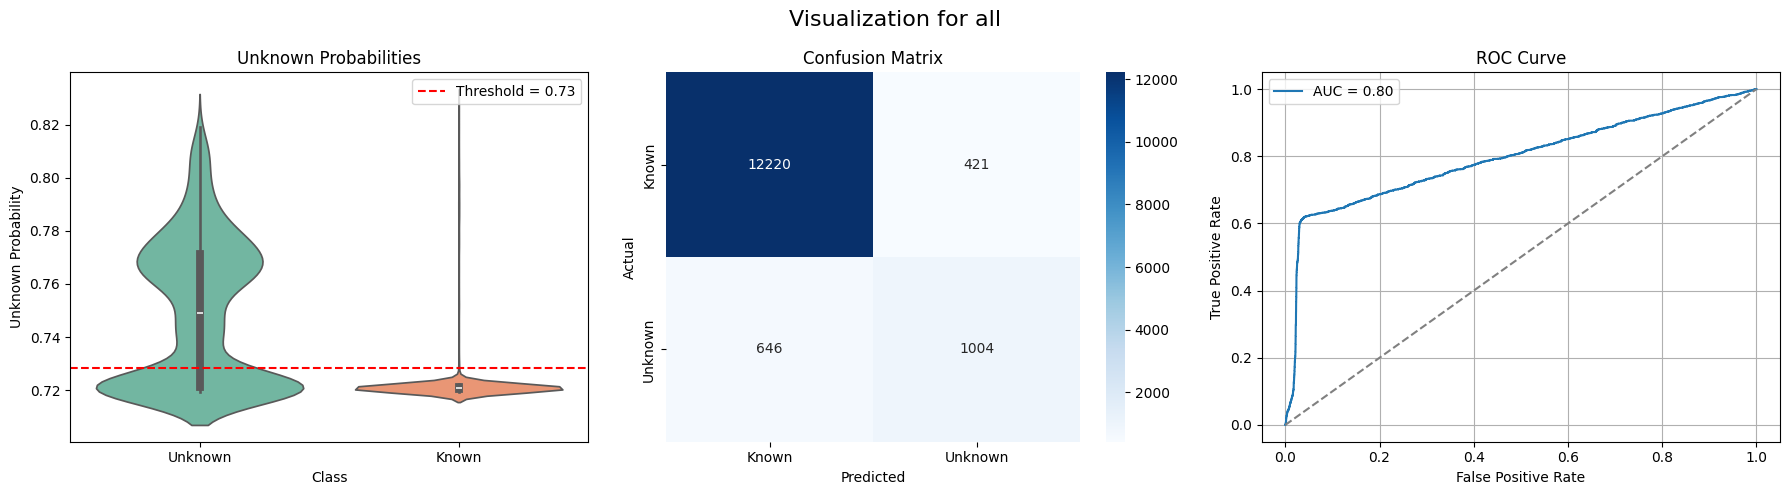

In [16]:
for name, res in results.items():
    plot_all_metrics(res, dataset_name=name, threshold=0.7282)


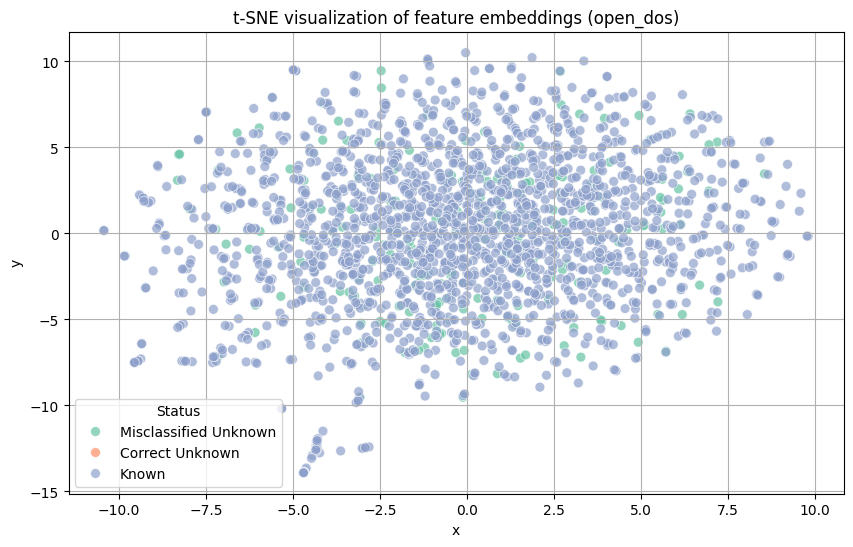

In [ ]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

# Chọn output của "open_dos"
res = results['open_dos']

X = res["total_feats"]
y_true = res["mapped_label"]
y_pred = res["mapped_pred"]
unk_probs = res["unk_probs"]

# Giảm chiều
tsne = TSNE(n_components=2, random_state=42, perplexity=30)
X_2d = tsne.fit_transform(X)

df_vis = pd.DataFrame({
    "x": X_2d[:, 0],
    "y": X_2d[:, 1],
    "TrueLabel": y_true,
    "PredLabel": y_pred,
    "UnkProb": unk_probs
})

# Tô màu theo các nhóm:
def status(row):
    if row["TrueLabel"] == 1 and row["PredLabel"] == 0:
        return "Misclassified Unknown"
    elif row["TrueLabel"] == 1:
        return "Correct Unknown"
    else:
        return "Known"
df_vis["Status"] = df_vis.apply(status, axis=1)

# Vẽ scatter
plt.figure(figsize=(10, 6))
sns.scatterplot(data=df_vis, x='x', y='y', hue='Status', palette="Set2", s=50, alpha=0.7)
plt.title('t-SNE visualization of feature embeddings (open_dos)')
plt.grid(True)
plt.show()


In [24]:
def extract_features(model, classifier, dataloader, device):
    model.eval()
    classifier.eval()
    features = []
    labels = []
    with torch.no_grad():
        for images, targets in dataloader:
            images = images.to(device)
            output = model.encoder(images)  # output shape: [B, D]
            features.append(output.cpu())
            labels.append(targets.cpu())
    features = torch.cat(features, dim=0)
    labels = torch.cat(labels, dim=0)
    return features.numpy(), labels.numpy()


In [25]:
from scipy.spatial.distance import cosine

sample_idx = 10  # ví dụ 1 sample bị nhầm
feat = res["total_feats"][sample_idx]
true_lbl = res["labels"][sample_idx]
pred_lbl = res["raw_preds"][sample_idx][0]
unk_prob = res["unk_probs"][sample_idx]

print(f"🔎 True Label: {true_lbl}, Predicted: {pred_lbl}, Unknown Prob: {unk_prob:.4f}")

# So sánh khoảng cách đến các class_means
distances = {
    cls: cosine(feat, mean) for cls, mean in class_means.items()
}
sorted_distances = sorted(distances.items(), key=lambda x: x[1])
print("📐 Top 3 closest class means:")
for cls, dist in sorted_distances[:3]:
    print(f"Class {cls}: Distance = {dist:.4f}")


🔎 True Label: 1, Predicted: 0, Unknown Prob: 0.7039
📐 Top 3 closest class means:
Class 0: Distance = 0.0942
Class 2: Distance = 0.9874
Class 3: Distance = 0.9938


## REFIT WEIBULL


In [60]:
from rd_openmax import extract_class_stats, fit_weibull_rd, openmax_predict_mahalanobis

class_feats, class_means = extract_class_stats(model, classifier, train_loader, device)
weibull = fit_weibull_rd(class_feats, class_means, tailsize=45)

In [43]:
def evaluate_open_set(model, classifier, open_loader, device, best_thresh=0.7212):
    total_preds = []
    total_feats = []
    total_labels = []
    unk_probs = []

    model.eval()
    if classifier is not None:
        classifier.eval()

    with torch.no_grad():
        for images, labels in open_loader:
            if isinstance(images, (list, tuple)):
                images = images[0]

            images = images.to(device, non_blocking=True)
            labels = labels.to(device, non_blocking=True)

            # 🧠 Feature embedding
            feats = model.encoder(images) if classifier is not None else model(images)
            feats = F.normalize(feats, dim=1)
            feats_np = feats.cpu().numpy()
            total_feats.append(feats_np)

            for f, label in zip(feats_np, labels.cpu().numpy()):
                pred_class, unk_prob = openmax_predict_rd(f, class_means, weibull)
                total_preds.append((pred_class, unk_prob))
                total_labels.append(label)
                unk_probs.append(unk_prob)

    total_feats_np = np.concatenate(total_feats, axis=0)

    # Mapping labels: 0 = known, else = unknown
    mapped_label = [0 if l == 0 else 1 for l in total_labels]
    mapped_pred = [0 if p[1] < best_thresh else 1 for p in total_preds]

    return {
        "mapped_label": mapped_label,
        "mapped_pred": mapped_pred,
        "unk_probs": unk_probs,
        "total_feats": total_feats_np,
        "raw_preds": total_preds,
        "labels": total_labels
    }


In [61]:
maha_results = {}
for name in ['open_all', 'open_dos', 'open_double', 'open_force_neutral', 'open_fuzzing', 'open_triple']:
    print(f"🔍 Evaluating on: {name}")
    res = evaluate_open_set(
        model=model,
        classifier=classifier,
        open_loader=loaders[name],
        device=device,
        best_thresh=0.7212
    )
    maha_results[name] = res

🔍 Evaluating on: open_all
🔍 Evaluating on: open_dos
🔍 Evaluating on: open_double
🔍 Evaluating on: open_force_neutral
🔍 Evaluating on: open_fuzzing
🔍 Evaluating on: open_triple


In [62]:
evaluate_and_print_metrics(maha_results)


📁 Dataset: open_all
🔹 Accuracy: 95.62%
🔹 F1 Score: 0.8038
🔹 Precision: 0.8969
🔹 Recall: 0.7282
🔹 Confusion Matrix:
[[37103   442]
 [ 1435  3845]]

📁 Dataset: open_dos
🔹 Accuracy: 87.37%
🔹 F1 Score: 0.0565
🔹 Precision: 0.1333
🔹 Recall: 0.0359
🔹 Confusion Matrix:
[[1839   52]
 [ 215    8]]

📁 Dataset: open_double
🔹 Accuracy: 99.59%
🔹 F1 Score: 0.9932
🔹 Precision: 0.9881
🔹 Recall: 0.9983
🔹 Confusion Matrix:
[[1360    7]
 [   1  582]]

📁 Dataset: open_force_neutral
🔹 Accuracy: 91.51%
🔹 F1 Score: 0.0000
🔹 Precision: 0.0000
🔹 Recall: 0.0000
🔹 Confusion Matrix:
[[1434    0]
 [ 133    0]]

📁 Dataset: open_fuzzing
🔹 Accuracy: 97.55%
🔹 F1 Score: 0.8843
🔹 Precision: 0.8304
🔹 Recall: 0.9455
🔹 Confusion Matrix:
[[1803   39]
 [  11  191]]

📁 Dataset: open_triple
🔹 Accuracy: 99.59%
🔹 F1 Score: 0.9932
🔹 Precision: 0.9881
🔹 Recall: 0.9983
🔹 Confusion Matrix:
[[1360    7]
 [   1  582]]


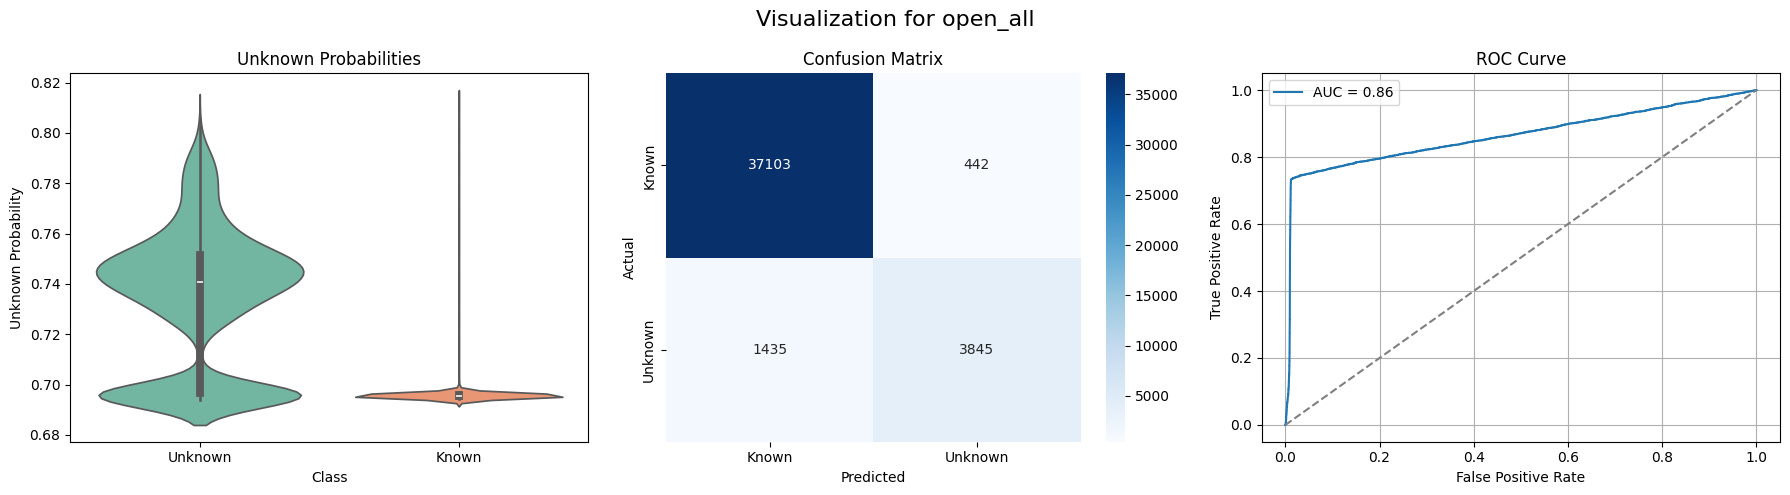

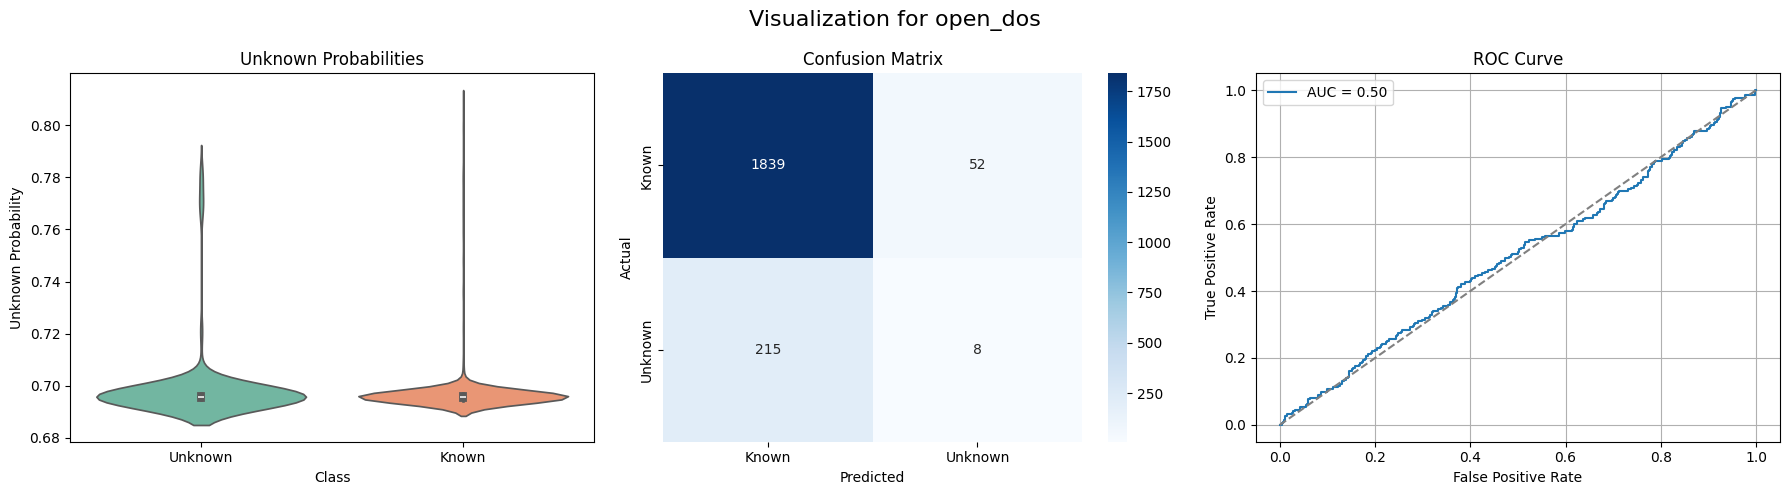

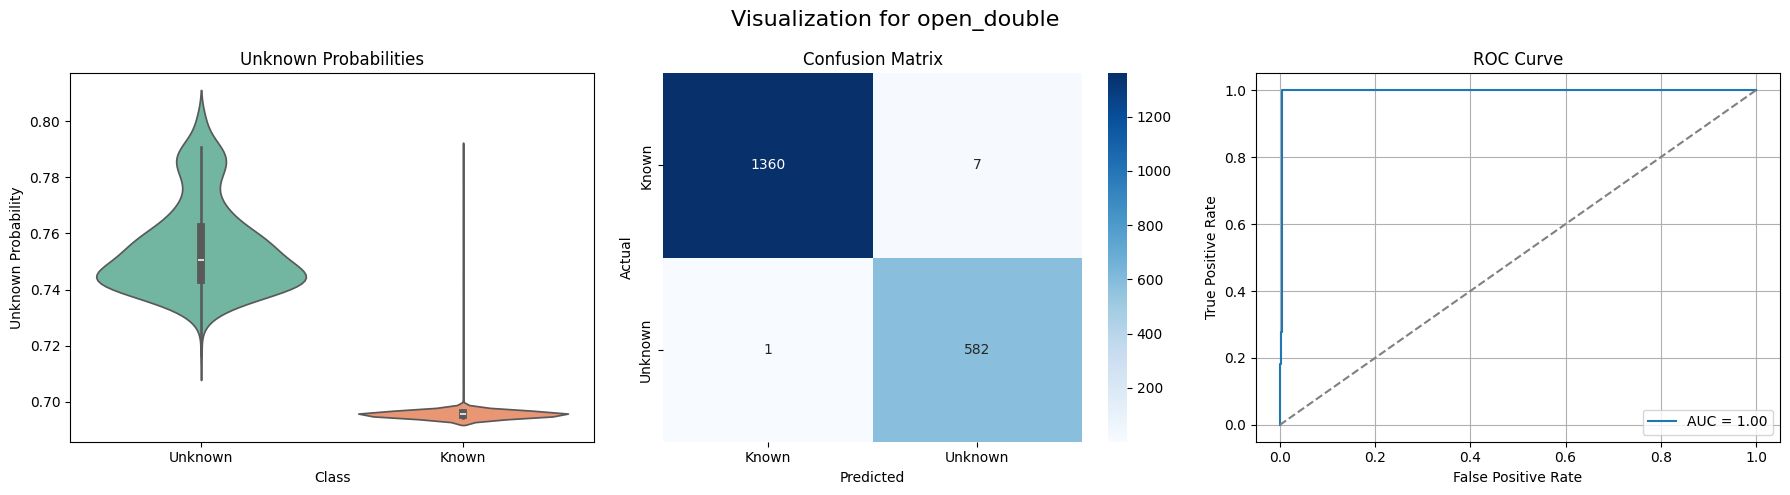

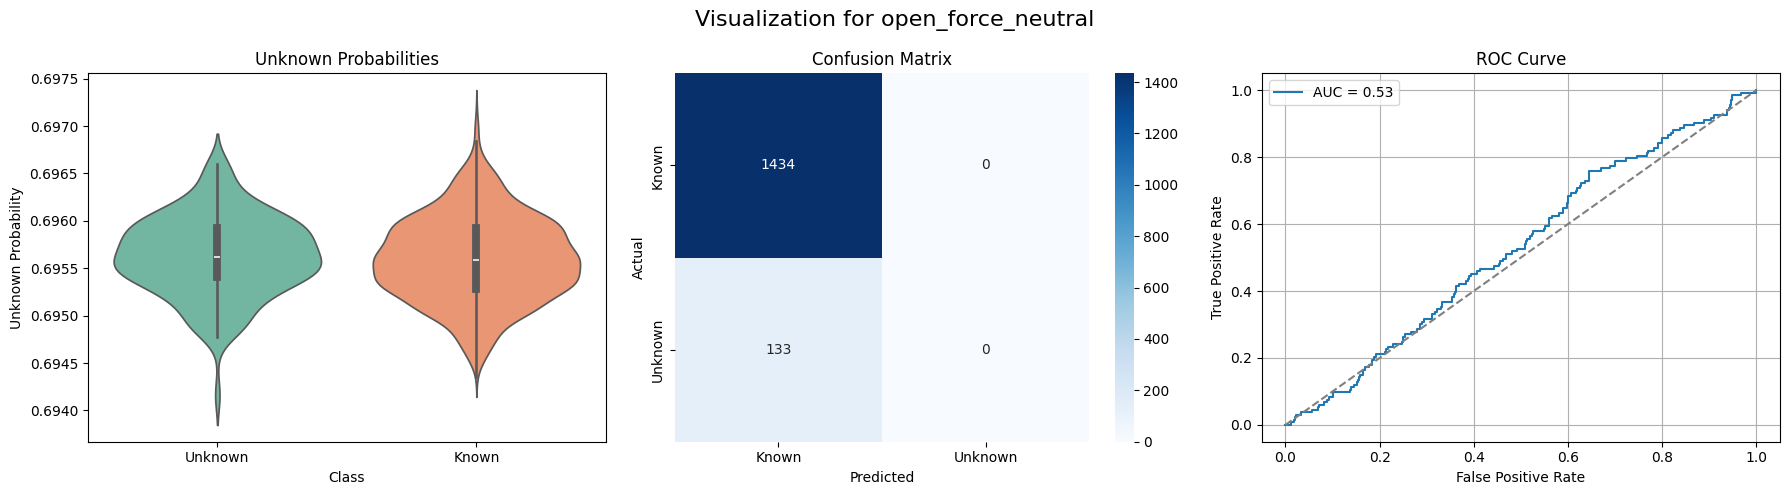

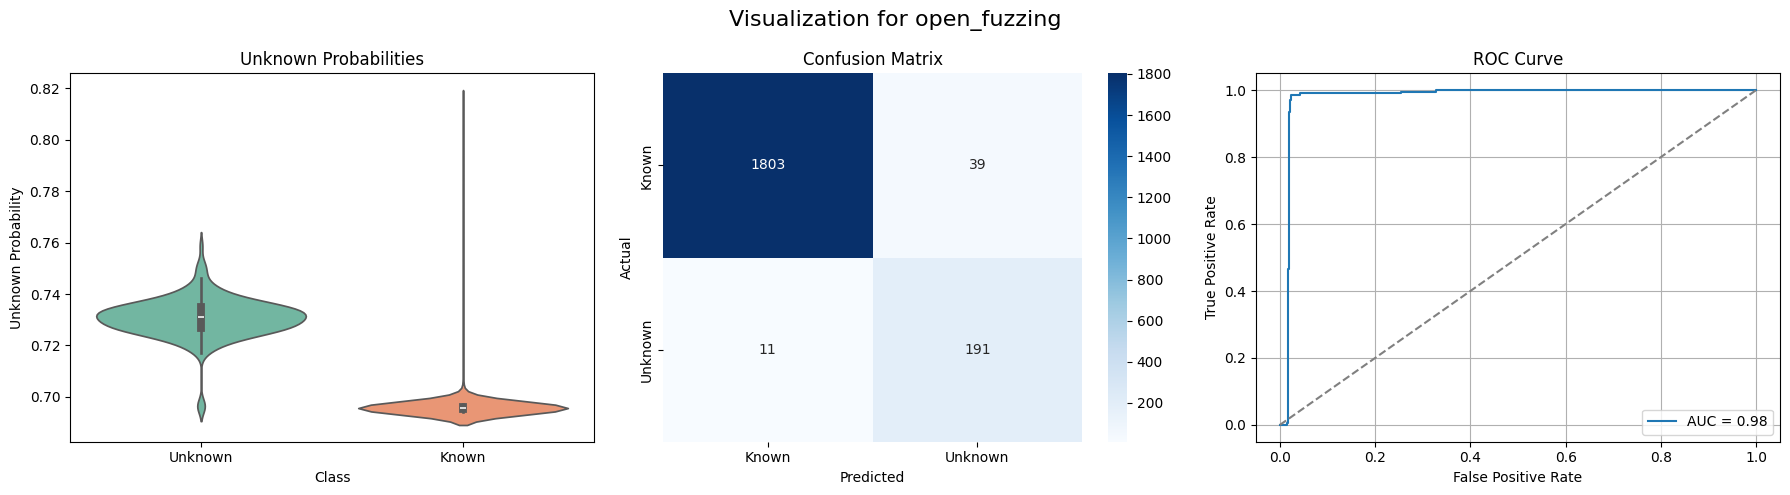

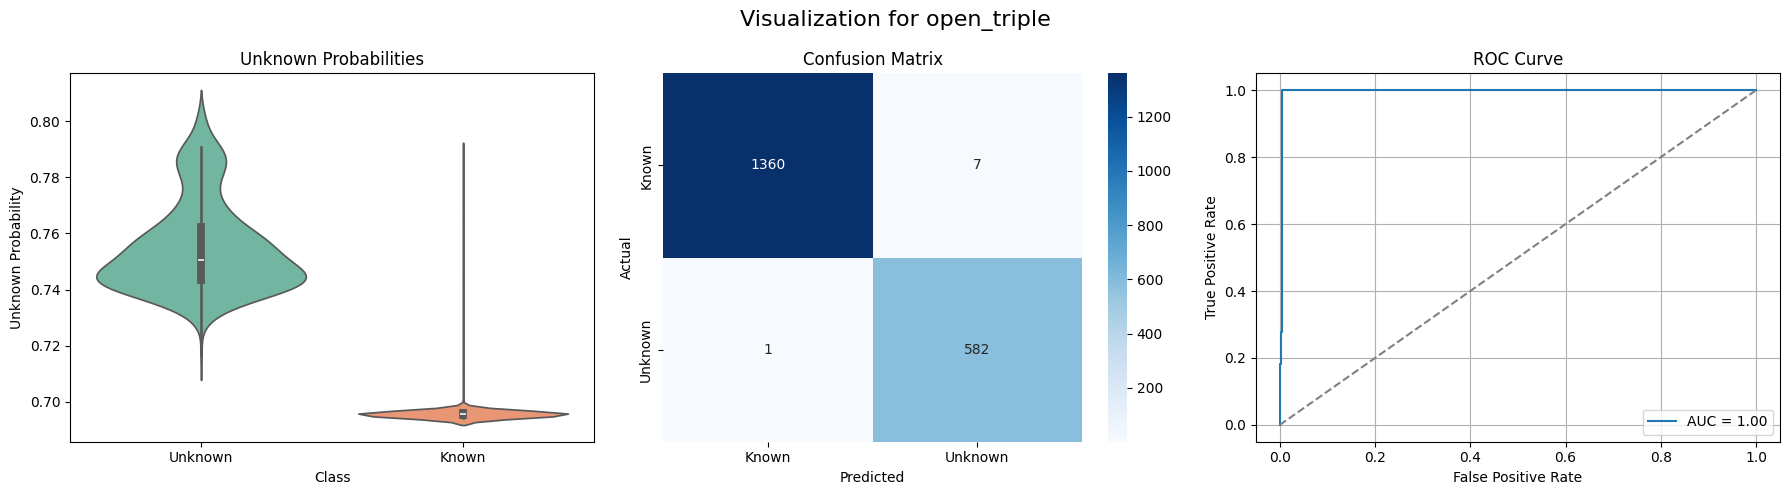

In [63]:
for name, res in maha_results.items():
    plot_all_metrics(res, dataset_name=name)

In [58]:
from sklearn.metrics import roc_auc_score, f1_score
import numpy as np
import matplotlib.pyplot as plt

tailsizes = [35, 40, 45, 50, 55]
results = []

threshold = 0.7212  # bạn có thể thử các giá trị khác như 0.6, 0.7 tùy độ phân biệt của unk_prob

# Step 1: Extract stats từ tập train
class_feats, class_means = extract_class_stats(model, classifier, train_loader, device)

for ts in tailsizes:
    print(f"\n🔍 Evaluating tailsize = {ts}")
    weibull = fit_weibull_rd(class_feats, class_means, tailsize=ts)

    total_labels = []
    unk_probs = []

    with torch.no_grad():
        for images, labels in loaders['open_all']:
            if isinstance(images, (list, tuple)):
                images = images[0]
            images = images.to(device, non_blocking=True)
            labels = labels.to(device, non_blocking=True)

            feats = model.encoder(images) if classifier is not None else model(images)
            feats = F.normalize(feats, dim=1)
            feats_np = feats.cpu().numpy()

            for f, label in zip(feats_np, labels.cpu().numpy()):
                _, unk_prob = openmax_predict_rd(f, class_means, weibull)
                total_labels.append(label)
                unk_probs.append(unk_prob)

    # 🎯 Known = 0, Unknown = anything else
    true_labels = np.array([0 if l == 0 else 1 for l in total_labels])
    pred_scores = np.array(unk_probs)

    # Convert probability to hard prediction using threshold
    pred_labels = (pred_scores > threshold).astype(int)

    # Calculate metrics
    try:
        auc = roc_auc_score(true_labels, pred_scores)
        f1 = f1_score(true_labels, pred_labels)
    except Exception as e:
        auc = 0.0
        f1 = 0.0
        print(f"⚠ Evaluation failed: {e}")

    print(f"✅ Tailsize {ts} → AUC = {auc:.4f}, F1 = {f1:.4f}")
    results.append((ts, auc, f1))

# 🎉 Tổng hợp
best_auc = max(results, key=lambda x: x[1])
best_f1 = max(results, key=lambda x: x[2])
print(f"\n🏆 Best AUC: tailsize={best_auc[0]}, AUC={best_auc[1]:.4f}")
print(f"🏆 Best F1:  tailsize={best_f1[0]}, F1={best_f1[2]:.4f}")



🔍 Evaluating tailsize = 35
✅ Tailsize 35 → AUC = 0.8617, F1 = 0.6419

🔍 Evaluating tailsize = 40
✅ Tailsize 40 → AUC = 0.8642, F1 = 0.7648

🔍 Evaluating tailsize = 45
✅ Tailsize 45 → AUC = 0.8650, F1 = 0.8083

🔍 Evaluating tailsize = 50
✅ Tailsize 50 → AUC = 0.8652, F1 = 0.8079

🔍 Evaluating tailsize = 55
✅ Tailsize 55 → AUC = 0.8652, F1 = 0.8021

🏆 Best AUC: tailsize=50, AUC=0.8652
🏆 Best F1:  tailsize=45, F1=0.8083


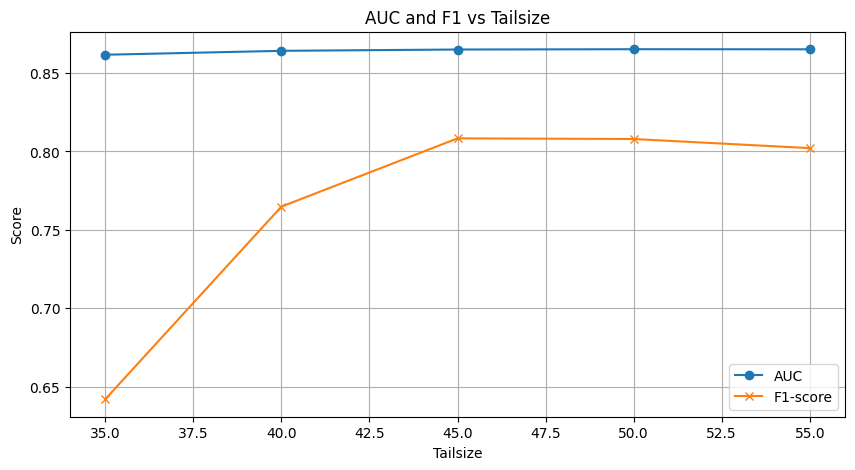

In [59]:
tails = [r[0] for r in results]
aucs = [r[1] for r in results]
f1s  = [r[2] for r in results]

plt.figure(figsize=(10,5))
plt.plot(tails, aucs, marker='o', label='AUC')
plt.plot(tails, f1s, marker='x', label='F1-score')
plt.xlabel('Tailsize')
plt.ylabel('Score')
plt.title('AUC and F1 vs Tailsize')
plt.legend()
plt.grid(True)
plt.show()